In [1]:
# NAFNet train by Noisy office

# The original implementation of NAFNet: https://github.com/megvii-research/NAFNet

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Jan 21 05:01:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    52W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!ls 

sample_data


In [4]:
!git clone https://github.com/kwcckw/Converted_noisy_office

Cloning into 'Converted_noisy_office'...
remote: Enumerating objects: 306, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 306 (delta 3), reused 16 (delta 1), pack-reused 284
Receiving objects: 100% (306/306), 80.87 MiB | 30.21 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (435/435), done.


In [5]:
!git clone https://github.com/kwcckw/NAFNet

Cloning into 'NAFNet'...
remote: Enumerating objects: 633, done.
remote: Counting objects: 100% (277/277), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 633 (delta 203), reused 199 (delta 151), pack-reused 356
Receiving objects: 100% (633/633), 16.21 MiB | 21.64 MiB/s, done.
Resolving deltas: 100% (334/334), done.


In [6]:
%cd NAFNet

/content/NAFNet


In [7]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.2/190.2 KB 17.2 MB/s eta 0:00:00


In [8]:
!python setup.py develop --no_cuda_ext

running develop
running egg_info
creating basicsr.egg-info
writing basicsr.egg-info/PKG-INFO
writing dependency_links to basicsr.egg-info/dependency_links.txt
writing top-level names to basicsr.egg-info/top_level.txt
writing manifest file 'basicsr.egg-info/SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'basicsr.egg-info/SOURCES.txt'
/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py:476: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))
running build_ext
Creating /usr/local/lib/python3.8/dist-packages/basicsr.egg-link (link to .)
Adding basicsr 1.2.0+85909bd to easy-install.pth file

Installed /content/NAFNet
Processing dependencies for basicsr==1.2.0+85909bd
Finished processing dependencies for basicsr==1.2.0+85909bd


In [9]:
# train
!mkdir -p /content/NAFNet/datasets/noisyoffice/train/clean
!cp -a /content/Converted_noisy_office/train/train/train_cleaned/. /content/NAFNet/datasets/noisyoffice/train/clean

!mkdir -p /content/NAFNet/datasets/noisyoffice/train/noisy
!cp -a /content/Converted_noisy_office/train/train/train_noisy/. /content/NAFNet/datasets/noisyoffice/train/noisy

# validate
!mkdir -p /content/NAFNet/datasets/noisyoffice/validate/clean
!cp -a /content/Converted_noisy_office/validate/validate/validate_cleaned/. /content/NAFNet/datasets/noisyoffice/validate/clean

!mkdir -p /content/NAFNet/datasets/noisyoffice/validate/noisy
!cp -a /content/Converted_noisy_office/validate/validate/validate_noisy/. /content/NAFNet/datasets/noisyoffice/validate/noisy


# test
!mkdir -p /content/NAFNet/datasets/noisyoffice/test/clean
!cp -a /content/Converted_noisy_office/test/test/test_cleaned/. /content/NAFNet/datasets/noisyoffice/test/clean

!mkdir -p /content/NAFNet/datasets/noisyoffice/test/noisy
!cp -a /content/Converted_noisy_office/test/test/test_noisy/. /content/NAFNet/datasets/noisyoffice/test/noisy

!mkdir -p /content/NAFNet/datasets/noisyoffice/test/clean_predicted

# Binarize the Groundtruth

Here we make sure to Otsu binarize the groundtruth images, since we're training the binarizing denoiser. We'll define a function to do it, then parallelize across a process pool.

In [10]:
# from pathlib import Path
# import cv2
# import os
# from multiprocessing import Pool
# import numpy as np

# # A utility function for preprocessing
# def grayscale(image_path: Path):
#     # read the images in as f32 arrays, for increased precision
#     img = cv2.imread(image_path.as_posix()).astype(np.float32)

#     # grayscale image
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#     # normalize pixel intensity values to the 8-bit range (still f32)
#     img = img / 255.0

#     return img.astype(np.uint8)

# train_clean_path = Path("/content/NAFNet/datasets/noisyoffice/train/clean")
# train_clean_list = [f for f in train_clean_path.iterdir()]

# def binarize_groundtruths(filename: Path):
#   clean = grayscale(filename)
#   out, binary = cv2.threshold(clean,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#   cv2.imwrite(filename.as_posix(), binary)


# pool = Pool(os.cpu_count())
# pool.map(binarize_groundtruths, train_clean_list)

In [11]:
from pathlib import Path
import cv2
import os
from multiprocessing import Pool
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
from skimage.filters import (threshold_otsu, threshold_niblack, threshold_sauvola)
from skimage import io
from skimage.color import rgb2gray
from google.colab.patches import cv2_imshow

WS_NIBLACK = 25
WS_SAUVOLA = 25

def niblack(img, window_size=WS_NIBLACK, k=0.8):
  th = threshold_niblack(img, window_size, k)
  bin_img = img > th
  return bin_img

def sauvola(img, window_size=WS_SAUVOLA):
  th = threshold_sauvola(img, window_size)
  bin_img = img > th
  return bin_img

def otsu(img):
  bin_img = img > threshold_otsu(img)
  return bin_img

def ensemble_average_binarize(img):
  a = niblack(img) * 1.0
  b = sauvola(img) * 1.0
  c = otsu(img) * 1.0
  m = (a + b + c) / 3
  return m > 0.5

def binarize_groundtruths(filename: Path):
  # read the images in as f32 arrays, for increased precision
  img = rgb2gray(io.imread(filename.as_posix()))
  binarized = ensemble_average_binarize(img).astype(np.float32)
  io.imsave(filename.as_posix(), binarized)

In [12]:
train_clean_path = Path('/content/NAFNet/datasets/noisyoffice/train/clean/')
test_clean_path = Path('/content/NAFNet/datasets/noisyoffice/test/clean/')
val_clean_path = Path('/content/NAFNet/datasets/noisyoffice/validate/clean')

train_clean_list = [f for f in train_clean_path.iterdir()]
test_clean_list = [f for f in test_clean_path.iterdir()]
val_clean_list = [f for f in val_clean_path.iterdir()]

pool = Pool(os.cpu_count())
pool.map(binarize_groundtruths, train_clean_list)
pool.map(binarize_groundtruths, test_clean_list)
pool.map(binarize_groundtruths, val_clean_list)

float64float64float64
float64float64


float64
float64float64
float64
float64

float64


float64

float64


float64
float64
float64

float64float64




float64
float64

float64float64



float64



float64
float64


float64


float64


float64
float64
float64float64
float64float64


float64



float64

float64

float64



float64


float64
float64


float64


float64


float64

float64



float64

float64
float64

float64

float64float64float64

float64

float64


float64

float64


float64float64

float64


float64
float64float64



float64
float64


float64

float64

float64

float64float64



float64float64
float64



float64


float64

float64



float64float64


float64


float64float64

float64


float64
float64


float64


float64float64

float64

float64float64



float64

float64
float64

float64
float64float64

float64


float64


float64


float64


float64


float64float64

float64

float64
float64
float64


float64


float64float64float64


float64


float64float64
float64

float64float64


float64


float64

float64


float64float64

float64
float64
float64
float64


float64float64

float64float64



float64


float64


float64

float64


float64

float64

float64float64


float64


float64
float64

float64

float64

float64


float64
float64


float64float64float64float64

float64float64
float64float64float64
float64


float64

float64




float64float64

float64float64

float64
float64float64
float64float64



float64

float64

float64


float64

float64
float64



float64

float64float64

float64float64

float64



float64
float64

float64

float64


float64
float64


float64float64float64
float64

float64



float64

float64

float64

float64


float64float64float64

float64


float64


float64
float64
float64


float64float64float64float64

float64float64
float64

float64
float64
float64
float64float64





float64


float64float64

float64


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

# Render Images
Here we take a look at what we're working with.

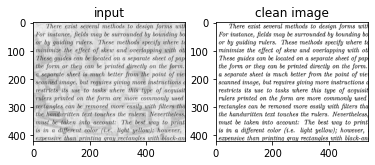

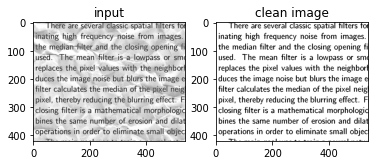

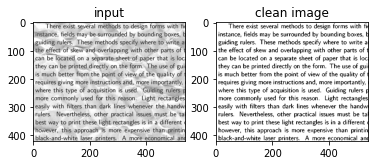

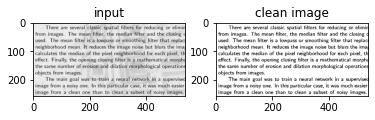

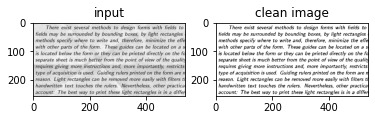

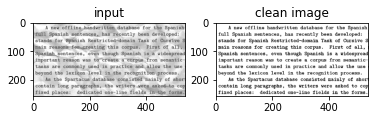

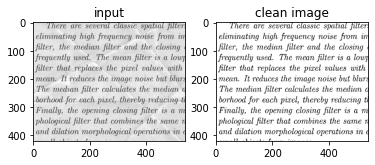

In [13]:
# Display some of the training images

from glob import glob
from matplotlib import pyplot as plt
import cv2

train_noisy_path = "/content/NAFNet/datasets/noisyoffice/train/noisy"
train_clean_path = "/content/NAFNet/datasets/noisyoffice/train/clean"

noisy_sample = glob(train_noisy_path+'/*.png')
clean_sample = glob(train_clean_path+'/*.png')

for i, (noisy_path, clean_path) in enumerate(zip(noisy_sample, clean_sample)):
    img_noisy = cv2.imread(noisy_path, cv2.IMREAD_GRAYSCALE)
    img_clean = cv2.imread(clean_path, cv2.IMREAD_GRAYSCALE)
    
    plt.figure()
    plt.subplot(121)
    plt.imshow(img_noisy,cmap='gray')
    plt.title('input')
    plt.subplot(122)
    plt.imshow(img_clean,cmap='gray')
    plt.title('clean image')

    if i >5:
        break



In [14]:
# train

!python train.py -opt "/content/NAFNet/options/train/SHABBY/noisyoffice_x64.yml"

run
Disable distributed.
2023-01-21 05:01:53,107 INFO: 
                ____                _       _____  ____
               / __ ) ____ _ _____ (_)_____/ ___/ / __ \
              / __  |/ __ `// ___// // ___/\__ \ / /_/ /
             / /_/ // /_/ /(__  )/ // /__ ___/ // _, _/
            /_____/ \__,_//____//_/ \___//____//_/ |_|
     ______                   __   __                 __      __
    / ____/____   ____   ____/ /  / /   __  __ _____ / /__   / /
   / / __ / __ \ / __ \ / __  /  / /   / / / // ___// //_/  / /
  / /_/ // /_/ // /_/ // /_/ /  / /___/ /_/ // /__ / /<    /_/
  \____/ \____/ \____/ \____/  /_____/\____/ \___//_/|_|  (_)
    
Version Information: 
	BasicSR: 1.2.0+85909bd
	PyTorch: 1.13.1+cu116
	TorchVision: 0.14.1+cu116
2023-01-21 05:01:53,108 INFO: 
  name: noisyoffice_x64
  model_type: ImageRestorationModel
  scale: 1
  num_gpu: 1
  manual_seed: 10
  datasets:[
    train:[
      name: noisyoffice-train
      type: PairedImageDataset
      dataroot_gt: datas

In [15]:
# mount gdrive

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [16]:
# copy model weights

!!mkdir -p /content/gdrive/MyDrive/ICDAR_models/NAFNet/model_weights_noisyoffice
!cp -a /content/NAFNet/experiments/. /content/gdrive/MyDrive/ICDAR_models/NAFNet/model_weights_noisyoffice